In [ ]:
# Using DASK on HPC systems such as Leonardo
**Recommended youtube:** [Matthew Rocklin](https://www.youtube.com/watch?v=FXsgmwpRExM&t=121s)
https://www.youtube.com/watch?v=FXsgmwpRExM&t=121s

**B.Chandramouli, A.Emerson**

**HPC Dept Cineca**

In [1]:
from datetime import datetime
from IPython.display import display, Markdown

todays_date = str(datetime.now().date())

display(Markdown(f'#### Last update {todays_date}'))

#### Last update 2023-10-11

## Introduction to Dask
 - Dask makes it easy to scale Python libraries like NumPy, pandas, and scikit-learn
 - Dask can also parallelize any Python code (not described here)
 - For arrays, dataframes, and other high-level collections, Dask achieves the parallelization by dividing the objects into *chunks* or *partitions*, which can be distributed over multiple CPUs or GPUs.
 - The collections are then used to create a task graph which can be executed by schedulers on a single machine or a cluster




<img src="svg/dask-graph.png" height="1000" width="800"/>

### Distributing data structures with dask
Lets consider the following Python structures: list-type objects, arrays and dataframes:

<img src="svg/collect1.png" width="400" height="600"/>

These structures can be divided among 1 or more *workers* to which are assigned CPU/GPU and some memory. 
The *scheduler* will manage the creation and communication between the workers, as well as providing statistics
on the problem being solved


<img src="svg/collect2.png" width="800" height="600"/>

----------------

> Setting-up a dask sheduler on a single machine (e.g. cloud instance) is relatively straightforward. In this study 
instead we concentrate on how to implement Dask on an HPC cluster, in particular using GPUs. 

-----------------

## Dask on HPC (Leonardo)

Overview of the ways of interacting with a supercomputing cluster with a scheduler such as SLURM, PBS, etc.


<img src="svg//dask-hpc-all.png" height="800" width="1000"/>

-------------------------------------------------------------------------------------------------------------------------
## HPC Strategy

There are three strategies for using a Dask  on a machine (e.g. Leonardo) with a batch system (e.g. Slurm):
    
1. Run the Dask sheduler on a login node (or compute node) of Leonardo and submit workers as Slurm jobs (debugging or setup)
2. Submit directly a slurm job in which the Dask sheduler and cluster are created (**preferred for single node GPUs**)
3. Use Dask-mpi, setting up the dask mpi scheduler in a slurm job with an MPI client (**preferred for CPUs**)
    
The first is more convenient and can be achieved with ipython or better jupyter-lab with tunneling to show the 
jupyter client and the dask scheduler on a PC. However, the slurm jobs of the workers may not all start at the same time.

The second method is less flexible, you have to decide a priori what resources you need, but you can still use 
tunneling to monitor the dashboard. On the other hand you would need to do this for very long calculations. **BUT you can only use the resources of one node.**

In the third case, you submit a SLURM job with Dask MPI as the scheduler on 1 rank, and the workers on the other ranks. Allows multiple node jobs. **BUT currently you cannot use GPUs with Dask MPI.**

In all cases, with appropriate tunnelling, you can monitor the dask dashboard.

*NB: Note the use of SLURM Heterogenous job support (HETJOB) to allocate different resources to the scheduler and workers*

-------------------------------------------------------------------------------------------------------------------------------

## Setup Dask, Rapids, jupyter and tunnelling for Interactive Dask

**_Steps_** 
1. Install Rapids and DASK in an environment (conda or pip) on Leonardo
2. Install jupyter-lab on Leonardo, and install Dask+Rapids env as a jupyter kernel (instructions [here](https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084))
3. Activate jupyter in server mode
4. Open a shell on local client and enable tunnelling for bother jupyter and dask

### On Leonardo
Login, activate Rapids+Dask environment and launch server-side jupyter
```bash
ssh login.leonardo.cineca.it  ## logon to leonardo  (e.g. WSL bash shell)
host=$(hostname) ## make note of hostname on leonardo
conda activate rapids-23.08   ## activate dask and rapids
jupyter-lab --no-browser --ip $host  ## set up browser for tunnelling
```

### On local PC
Open up a new shell on the PC and setup tunneling for both jupyter (port 8888) and Dask dashboard  server (8787)

Use the same login node as above
```bash
## assume login was on login01
ssh -N -L 8787:login01.leonardo.local:8787 -L 8888:login01.leonardo.local:8888 login.leonardo.cineca.it
```
Now open a browser window 
```
localhost:8888/lab
```
Optionally you can set up a password - instructions see you-tube video above.
On start up choose the rapids + dask kernel.

## Getting started


In [1]:
# Import dask and related modules.
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [3]:
# For Leonardo and HPC systems need batch scheduler interface
from distributed import Client
from dask_jobqueue import SLURMCluster


In [4]:
# Next step is to start a SLURM Cluster
# we define the characteristics of eack worker
cluster = SLURMCluster(cores=1,
                       processes=1,
                       memory="16GB",
                       account="cin_staff",
                       walltime="00:30:00",
                       interface="ib0",
                       job_extra_directives=['--tasks-per-node=1']
                       )
# Add more workers (i.e. SLURM jobs)
cluster.scale(2)


In [6]:
# define the client - from now on all caclulations will be done with the client
client = Client(cluster)

# check SLURM job script is valid with job_script()
print(cluster.job_script()) 


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A cin_staff
#SBATCH --cpus-per-task=1
#SBATCH --mem=15G
#SBATCH -t 00:30:00
#SBATCH --nodes=1

/leonardo/home/userinternal/aemerson/mambaforge/envs/rapids-23.08/bin/python -m distributed.cli.dask_worker tcp://10.128.0.2:46139 --nthreads 1 --memory-limit 14.90GiB --name dummy-name --nanny --death-timeout 120 --local-directory $TMPDIR --interface ib0



#### Check the job script

It is a bit trickty getting the right options for SLURM for Leonardo. So **check carefully**
the jobscript obtained above. You may need to use `job_extra_directives` option fine-tune the job script.

Recommended to use the `jobscript.yaml` file to make sensible defaults for the cluster, overriding if necessary.

In [7]:
## check client directly, also get dashboard ip
client

<Client: 'tcp://10.128.0.2:46139' processes=2 threads=2, memory=29.80 GiB>

### Simple example

Now let us give out cluster some work to do.
Remember to check the dashboard and `squeue` on Leonardo to see the jobs being submitted. 

In [ ]:
# Simple Matrix operations - they will now use the SLURM cluster
## check with squeue on Leonardo
import dask.array as da
x=da.random.random((30000,30000),chunks=(1000,1000))
print(x)
x=x.persist()            # compute object, but keep it distributed among partitions
y=(x+x.T)-x.mean(axis=0)
y=y.persist()


dask.array<random_sample, shape=(30000, 30000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>


In [ ]:
x

### Shutting down the server

Recommend, also because batch jobs will stay waiting 

In [13]:
client.cluster.close(),client.close()

(None, None)

## Dask MPI
Using Dask in an MPI environment allows us to use multiple nodes for our Dask cluster.
In dask mpi, `mpi4ypy` is used to allocate the resources which the workers then connect to but,  **very important**, you must allocate
N+2 tasks for N workers since 2 tasks are used for the sheduler and the client.
Bear in mind also MPI _does not handle communications_, tcp is the default.

### How to run a dask mpi job
In the slurm batch job use mpirun to launch the client:
```bash
mpirun python client-py
```
The client needs the following code:
```python
from dask_mpi import initialize
initialize(interface='ib0',nanny=False) 

from distributed import Client
client = Client()
# do something here
client.close()  # this gives errors but does not affect execution (https://github.com/dask/dask-mpi/issues/94)

```
In addition, it is recommended to print the address of the dashboard which you can tunnel to when the job starts.
```python
# tunnelling info for dashboard
import socket
host = client.run_on_scheduler(socket.gethostname)
port = client.scheduler_info()['services']['dashboard']
login_node_address = "login.leonardo.cineca.it" # Provide address/domain of login node

print(f"ssh -N -L {port}:{host}:{port} {login_node_address}")
sleep(30) # to give time to start the tunneling
```
Note that MPI is used to start the jobs but not perform the communication, which by default is tcp (need to check if the infiniband interface works)

### GPUs
For the moment DASK MPI does *not* seem to work with GPUs.
The problem is due to the fact it is not possible to ovverride the 'nanny' option when using  CUDA workers.
There is an open git issue: (https://github.com/rapidsai/dask-cuda/issues/741) but there appears no interest in resolving it.

### Issues
- Havent quite worked out how to divide correctly up the resources (thread, memory, processes,etc) from the batch job to the workers
- Havent checked if the infiniband option is really using infiniband

----------------------------------------------------------------------

### Quick note on Rapids and dask

NVIDIA CUDA-based tools for dataframes, machine learning, and many other statistical or processing methods.

#### cuDF
cuDF is a Python GPU DataFrame library (built on the Apache Arrow columnar memory format) for loading, joining, aggregating, filtering, and otherwise manipulating tabular data using a DataFrame style API in the style of pandas. It can be very much faster than pandas on the CPU.

**Usage**

If using 1 GPU then cudf (without dask) as a drop-in replacement for pandas  is probably fine. 

For larger jobs you should either use some chunking mechanism or better use dask with cudf.
  

```python
import cudf
import dask_cudf
df=cudf.read_csv(file)
ddf=dask_cudf.read_csv(...)   # uses cudf to read the csv
```

`cudf` has most of the features of pandas, but there are differences so you should check the [documentation](https://docs.rapids.ai/api/cudf/stable/user_guide/pandas-comparison/).

---------------------------------------------------------------------

## GPU-based benchmark on Leonardo with Rapids and Dask

### Objective
Read a very-large csv file (output from Ligen) and generate statistics.

### Procedure
1. Try first with standard Pandas tools
2. Set up a SLURM cluster, requesting GPUS for the calculations
3. Launch calculation based on Rapids (GPU-based python tools) and dask

We will launch directly batch jobs, monitoring the dashboard with tunneling.



#### Datafile
The datafiles, when read into a dataframe, look like this, but could be any csv file:


In [12]:
df=pd.read_csv("../src/small.csv")
cols=['protein'+str(x) for x in range (1,20)]
cols.insert(0,'smiles')
df.columns=cols

In [4]:
df.head()

,smiles,protein1,protein2,protein3,protein4,protein5,protein6,protein7,protein8,protein9,protein10,protein11,protein12,protein13,protein14,protein15,protein16,protein17,protein18,protein19
0,CNc1c2c(c(c3cn[nH]c13)[N+](=O)[O-])C(C)(C)CC2(C)C,6.0981,5.9375,5.4992,5.1303,6.5374,6.0869,6.3480,6.7155,7.3324,6.4307,6.4635,7.2204,5.5936,6.9838,4.5256,5.8861,5.3606,6.2113,5.7935
1,CNc1c2CCCc2cc3C=C(C)Cc13,4.0999,1.9553,4.1166,3.5783,3.5643,4.6520,5.2459,3.0994,3.8211,3.0018,5.2026,5.1380,4.7990,3.8637,2.6954,4.3579,3.9744,3.4655,3.7040
2,CNc1c2CCCc2cc3C(=O)C(C)Cc13,3.5742,4.7209,4.5258,4.6555,4.2643,3.2156,4.8925,3.4152,4.6031,4.2604,5.8570,4.7310,5.3198,3.7583,2.8480,3.7759,5.8479,4.2895,5.3379
3,CNc1c2CCCc2c(C#N)c3nc4ccccc4n13,3.8752,2.2390,4.2739,4.3713,5.1142,5.6888,5.4354,6.5651,5.9014,4.3595,5.5669,7.3213,4.1309,4.4972,3.1692,3.3411,5.0769,6.1888,4.5990
4,CNc1c2CCCc2nc3c(Br)cnn13,3.0625,2.5276,1.8407,4.4455,4.5818,4.4631,4.0208,4.2331,5.1412,3.6220,5.4550,3.6272,3.7502,2.9225,2.4910,5.2443,4.1639,3.3622,5.2098


In [ ]:
The first column represents a smile string (representing a molecule),
while the other columns represent 'scores', estimating the
binding that molecule against a protein target (and hence the potential as a drug).

In [ ]:
#### Pandas code

We do a simple dataframe read for both pandas and dask-cudf
```python
import pandas as pd
import dask_cudf as ddf

df=pd.read_csv(filename,header=None).set_index("smiles") # also read_csv(file,index_col=0) but there is an issue with dask
df.describe()

ddf=pd.read_csv(filename,header=None).set_index("smiles")
ddf.persist() # resolve the ddf, but still in parallel
ddf.describe(datetime_is_numeric=True).compute())   # compute the stats
```


#### For DASK+CUDA we set up a CUDA cluster and use rapids (dask_cudf)
```python
### Dask set up
from dask_cuda import LocalCUDACluster
import dask_cudf as dd
from dask.distributed import Client, progress, wait

cluster = LocalCUDACluster() # rmm_pool_size = '28GiB')
client = Client(cluster)
print(client)
host = client.run_on_scheduler(socket.gethostname)
port = client.scheduler_info()['services']['dashboard']
login_node_address = "login.leonardo.cineca.it" # Provide address/domain of login node
print(f"ssh -N -L {port}:{host}:{port} {login_node_address}",flush=True)
sleep(30)  # give time to set up tunneling
'''
pandas code
'''
```


### Resources

1. Pandas
2. Dask+ Cudf (from Nvidia Rapids)


#### We are now ready to submit the following [batch job](batch-dask-cuda.sh)

In [5]:
!cat batch-dask-cuda.sh

#!/bin/bash
#SBATCH -N1 --tasks-per-node=4
#SBATCH -p boost_usr_prod 
#SBATCH -t 30:00
#SBATCH --mem=100GB
#SBATCH --gres=gpu:4
#SBATCH -A cin_staff

module load cuda
prog="run-dask.py"
datafile="$CINECA_SCRATCH/very_huge.csv"
#source $HOME/modin/bin/activate
. "/leonardo/home/userinternal/aemerson/mambaforge/etc/profile.d/conda.sh"
. "/leonardo/home/userinternal/aemerson/mambaforge/etc/profile.d/mamba.sh"
mamba activate rapids-23.08
python ../src/run-dask-cuda.py -f $datafile > very_huge.out


## Results

*Disclaimer*: using only default parameters. No attempt to optimize for either Dask or Pandas.
For Dask we invoke the `persist()` method to load the dataframe into memory.

### Read csv

| file | file size (Gb)| Pandas (s)| Dask (GPU) (s)|
| ------|---------------|--------|---------- |
| small | 4.1 | 35.4 |5.9 |
| medium | 8.2 | 70.0| 6.9 |
| very big | 17.0 | 138.0 | 11.8|
| huge | 33.0 | 273.4 |17.5 |
| very huge | 66.0 | 546.7|33.1 |


### df.describe()

| file |  file size (Gb) |Pandas | Dask |
| -----|---|---|--------|
| small | 4.1|  16.3|5.1|
| medium | 8.2| 32.3| 11.0|
| very big |17.0| 71.5|22.8|
| huge | 33.0| 170.0| 45.8| 
| very huge |66.0| 344.8| 105.7|



In [2]:
## dataframes
filesize=['4.1','8.2','17.0','33.0','66.0']
df_read=pd.DataFrame.from_dict({'file size(Gb)': filesize, 'pandas': [ 35.4,70.0, 138.0, 273.4,546.7] , 
                                'dask_cudf' : [5.9,6.9,11.8,17.5,33.1]})
df_describe=pd.DataFrame.from_dict( {'file size(Gb)': filesize, 'pandas':[16.3, 32.3, 71.5, 170.0, 344.8],
                                'dask_cudf' : [5.1, 11.0, 22.8, 45.8, 105.7] })

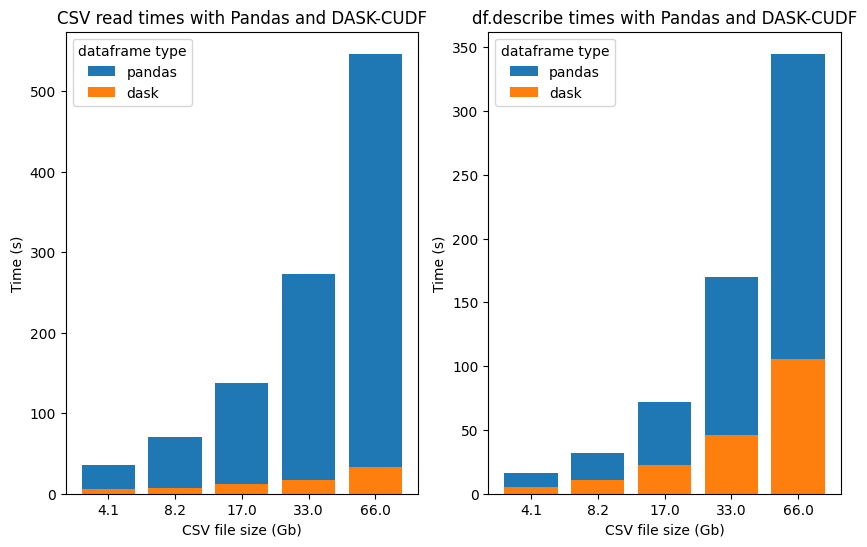

In [33]:
## graphs
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,sharex=True)
    
ax[0].bar(filesize,df_read['pandas'],label='pandas')
ax[0].bar(filesize,df_read['dask_cudf'],label='dask')
ax[0].set_ylabel('Time (s)')
ax[0].set_xlabel('CSV file size (Gb)')
ax[0].legend(title="dataframe type")
ax[0].set_title("CSV read times with Pandas and DASK-CUDF")

ax[1].bar(filesize,df_describe['pandas'],label='pandas')
ax[1].bar(filesize,df_describe['dask_cudf'],label='dask')
ax[1].set_ylabel('Time (s)')
ax[1].set_xlabel('CSV file size (Gb)')
ax[1].legend(title="dataframe type")
ax[1].set_title("df.describe times with Pandas and DASK-CUDF")

#plt.subplots_adjust(bottom=0.1, right=1.5, top=1.0)
plt.rcParams['figure.figsize'] = [8, 6]

plt.savefig("svg/read_describe.svg")

<img src="svg/read_describe.svg" width=800 height=500></src>

-------------------------------------------------------------------------------------------------------

> For CSV read, Dask + GPU  is nearly **16 times faster** than plain Pandas on CPU. The describe function in our example is about **3 times faster**.

--------------------------------------------------------------------------------------------------------

## Sorting on GPUs

```python
from dask_cuda import LocalCUDACluster
import dask_cudf as dd
from dask.distributed import Client, performance_report

cluster = LocalCUDACluster()

with performance_report(filename="perf.html"):        
    ddf = dd.read_parquet(input_path+'/PARQUET_BROTLI/*', index='SMILES', columns ['3CL_6A']).sort_values('3CL_6A').persist()




## Current status in Ligate


Conversion of <mark>11Tb of csv files</mark> from the "Big Run " experiment of Exscalate4Cov into parquet files,
and removing duplicate entries (i.e. with multiple smiles strings ). 

- Achieved on 4 Leonardo nodes using CPUs in about 4 hours (remember dask mpi/CUDA problem), generating <mark>3 Tb of parquet files</mark>
    
### Work in progress ## 

- Construct DASK-powered pipeline for drug discovery


## Take home messages for Dask HPC

1. pandas is fine for small datasets which fit in local memory, but struggles with bigger ones
2. Good use case: dask for thinning very large data sets - then switch to use pandas
3. Dask + Nvidia rapids is a good combination for some operations (file conversions, datafames) but dask mpi (+CPU) is better for others (sorting).
4. Use `.persist()` instead of `.compute()` when possible. `.shuffle()` also really useful for grouping data on the same partition
5. Dask mpi would be most convenient for HPC, if were not for the CUDA problem.
6. Dont use csv with gzip - **parquet** is faster and smaller. In addition, numpy reads csv as 64 bit which is normally overkill - convert to 32 bit.
7. With GPUs and Rapids, 16 bit (or lower) might be an option. Also need to know how to test **NVLINK**.
8. Need to investigate Dask Gateway - could be very useful data analytics service.

## Experience with Dask

**Plus**

- Very powerful, with many features.
- Easy installation
- Integrates with pandas, Rapids, and most Python codes with few changes
- Dashboard is very useful (and cool)
- Integrates on the whole well with HPC


**Minus**

- Lots of features and parameters, not obvious the best way to do things
    - Considerable experimentation required, particularly with threads, workers and memory settings.
- Workers may die unexpectedly or become unresponsive if not used (cf with MPI)
    - Possible to add process pool to the thread pool (https://www.youtube.com/watch?v=vF2VItVU5zg)
- Some issues (e.g. MPI + CUDA) still not solved, and may never be.
